In [1]:
import numpy as np
import os

from sklearn.metrics import precision_recall_curve, auc
from sklearn.manifold import TSNE

from IPython.display import Image


import torch 
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.manifold import MDS

from torch.utils.data import TensorDataset, DataLoader, random_split, ConcatDataset

import matplotlib.pyplot as plt

In [2]:
def generator_loss(G_out, D_out,alpha, beta, power=2):
    loss_e = F.binary_cross_entropy(D_out, torch.full_like(D_out, alpha))
    
    center = torch.mean(G_out, dim=0)
    distance = torch.subtract(G_out, center)
    norm = torch.norm(distance, dim=(1,2,3), p=power)
    loss_d = torch.reciprocal(torch.mean(norm))
    
    return loss_e + beta * loss_d

def discriminator_loss(y_pred_real, y_pred_gen, gamma):
    real_loss = F.binary_cross_entropy(y_pred_real, torch.ones_like(y_pred_real))
    gen_loss = F.binary_cross_entropy(y_pred_gen, torch.zeros_like(y_pred_gen))
    
    return real_loss + gamma * gen_loss

In [3]:
class Hyperparameters:
    alpha = 0.1
    beta = 30
    gamma = 0.1
    batch_size = 200
    latent_dim = 200
    models_dir = "saved_models"
    pictures_dir = "pictures"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
args = Hyperparameters()

os.makedirs(args.models_dir, exist_ok=True)
os.makedirs(args.pictures_dir, exist_ok=True)

torch.manual_seed(123)
np.random.seed(123)

In [4]:
def train_discriminator(D, G, D_optimizer, X_real, args):
    G.eval()
    D.train()
    X_real = X_real.to(args.device)
    X_gen = torch.normal(0, 1, size=(args.batch_size, args.latent_dim)).to(args.device)
    
    y_pred_real = D(X_real)
    y_pred_gen = D(G(X_gen))

    loss = discriminator_loss(y_pred_real, y_pred_gen, args.gamma)

    
    D_optimizer.zero_grad()    
    loss.backward()
    D_optimizer.step()

    return loss.item()

def train_generator(D, G, G_optimizer, args):
    G.train()
    D.eval()
    X_gen = torch.normal(0, 1, size=(args.batch_size, args.latent_dim)).to(args.device)

    G_out = G(X_gen)
    D_out = D(G_out)
    loss = generator_loss(G_out, D_out, args.alpha, args.beta)

    G_optimizer.zero_grad()   
    loss.backward()
    G_optimizer.step()

    return loss.item()

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=200):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024)
        self.fc2 = nn.Linear(1024, 7*7*128)
        self.t_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.t_conv2 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(7*7*128)
        self.bn3 = nn.BatchNorm2d(64)
    
        for layer in [self.fc1, self.fc2, self.t_conv1, self.t_conv2]:
            torch.nn.init.normal_(layer.weight, mean=0, std=0.02)
        
       
    def forward(self, x):
        out = self.bn1(F.relu(self.fc1(x)))
        out = self.bn2(F.relu(self.fc2(out)))
        out = out.reshape(-1, 128, 7, 7)
        out = self.bn3(F.relu(self.t_conv1(out)))
        out = F.tanh(self.t_conv2(out))
        return out
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.conv1 = nn.Conv2d(1,64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(7*7*64,1024, 1024)
        self.fc2 = nn.Linear(1024, 1)
        
        for layer in [self.conv1, self.conv2, self.fc1, self.fc2]:
            torch.nn.init.normal_(layer.weight, mean=0, std=0.02)
       
    def forward(self, x):
     #   print(x.shape)
        out = x.reshape(-1, 1, 28, 28)
        out = self.leaky_relu(self.conv1(out))
        out = self.leaky_relu(self.conv2(out))
        out = out.reshape(-1, 7*7*64)
        out = self.leaky_relu(self.fc1(out))
        out = F.sigmoid(self.fc2(out))
        return out

In [6]:
def get_data(anomalous_class, batch_size=200):
    # load data 
    train_data = MNIST(root='./data/', train=True, download=True)
    test_data = MNIST(root='./data/', train=False, download=True)
    
    # concat data and preprocess
    X_full = torch.concat([train_data.data, test_data.data])
    y_full = torch.concat([train_data.targets, test_data.targets])
    preprocess = transforms.Lambda(lambda x : (x / 255 - 0.5) * 2)
    X_full = preprocess(X_full)
    
    # split normal and anomal classes
    y_normal_idx = y_full == anomalous_class
    X_normal = X_full[~y_normal_idx]
    X_anomal = X_full[y_normal_idx]
    
    # create data sets
    normal_dataset = TensorDataset(X_normal, torch.ones(X_normal.shape[0]))
    anomal_dataset = TensorDataset(X_anomal, torch.zeros(X_anomal.shape[0]))
    normal_train, normal_test = random_split(normal_dataset, [0.80, 0.20])
    anomal_dataset = ConcatDataset([anomal_dataset,normal_test])
    anomal_valid, anomal_test = random_split(anomal_dataset, [0.25, 0.75])
    
    #create data loaders
    normal_train_loader = DataLoader(normal_train, shuffle=True, drop_last=True, batch_size=batch_size)
    anomal_valid_loader = DataLoader(anomal_valid, batch_size=batch_size)
    anomal_test_loader = DataLoader(anomal_test, batch_size=batch_size)
    
    return normal_train_loader, anomal_valid_loader, anomal_test_loader

In [7]:
def compute_auprc(D, data_loader, device):
    D.eval()
    with torch.no_grad():
        y_prob_pred, y_true = np.array([]), np.array([])
        for data, targets in data_loader:
            data = data.to(args.device)
            p = D(data).cpu()
            y_prob_pred = np.append(y_prob_pred, p)
            y_true = np.append(y_true, targets)
    precision, recall, _ = precision_recall_curve(y_true, y_prob_pred)
    auprc = auc(recall, precision)
    return auprc

In [8]:
def visualize_G(G, train_loader, test_loader, device, n=200):
    G.eval()
    
    X_real_train = train_loader.dataset.dataset.tensors[0][:n].reshape(n,-1)
    X_real_anomal = test_loader.dataset.dataset.datasets[0].tensors[0][:n].reshape(n,-1)
    X_real_test = test_loader.dataset.dataset.datasets[1].dataset.tensors[0][:n].reshape(n,-1)

    In = torch.normal(0, 1, size=(n, args.latent_dim)).to(device)
    with torch.no_grad():
        X_fake = G(In).reshape(n,-1).cpu()

    X = torch.concat([X_real_train, X_real_test, X_fake, X_real_anomal]).numpy()
    #y = ['real_train']*n + ['real_test']*n + ['generated']*n + ['anomal']*n
    mds = MDS(n_components=2, random_state=0)
    X_2d = mds.fit_transform(X.astype(np.float64))
    plt.scatter(X_2d[:n, 0], X_2d[:n, 1], c='r', label='real_train')
    plt.scatter(X_2d[n:2*n, 0], X_2d[n:2*n, 1], c='orange', label='real_test')
    plt.scatter(X_2d[2*n:3*n, 0], X_2d[2*n:3*n, 1], c='b', label='generated')
    plt.scatter(X_2d[3*n:, 0], X_2d[3*n:, 1], c='g', label='anomalous')
    plt.legend()


In [9]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def save_fake_images(G, name, args):
    sample_vectors = torch.randn(100, args.latent_dim).to(args.device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fname = '{}/{}.png'.format(args.pictures_dir, name)
    save_image(denorm(fake_images), fname, nrow=10)
    return fname

# Train on full data

In [11]:
train_data = MNIST(root='./data/', train=True, download=True)
test_data = MNIST(root='./data/', train=False, download=True)
    
# concat data and preprocess
X_full = torch.concat([train_data.data, test_data.data])
preprocess = transforms.Lambda(lambda x : (x / 255 - 0.5) * 2)
X_full = TensorDataset(preprocess(X_full))
X_full_dataloader = DataLoader(X_full, shuffle=True, drop_last=True, batch_size=args.batch_size)

grid_values = [[1, 0, 1], [0.1, 30, 0.1]]
names = ['normal', 'FGAN']
#normal gan
for name, values in zip(names, grid_values):
    args.alpha, args.beta, args.gamma = values
    G = Generator().to(args.device)
    D = Discriminator().to(args.device)
    G_optimizer = Adam(G.parameters(), lr=2e-5, weight_decay=1e-4, betas=(0.5, 0.999))
    D_optimizer = Adam(D.parameters(), lr=1e-5, weight_decay=1e-4, betas=(0.5, 0.999))
    print("========== START TRAINING GAN -- {} ==========".format(name))
    for epoch in range(1, 15+1):
        for data in X_full_dataloader:
            _ = train_discriminator(D, G, D_optimizer, data[0], args)

    for epoch in range(1, 100+1):
        for data in X_full_dataloader:
            _ = train_discriminator(D, G, D_optimizer, data[0], args)
            _ = train_generator(D, G, G_optimizer, args)

        # valid
        if epoch % 20 == 0:
            g_path = "{}/g_baseline_{}_epoch_{}.pth".format(args.models_dir, name, epoch)
            d_path = "{}/d_baseline_{}_epoch_{}.pth".format(args.models_dir, name, epoch)
            torch.save(G.state_dict(), g_path)
            torch.save(D.state_dict(), d_path)
    print("========== END TRAINING GAN -- {} ==========".format(name))

100%|██████████| 9912422/9912422 [00:00<00:00, 92840021.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75426957.55it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34773318.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7271194.19it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

========== START TRAINING GAN -- normal ==========
========== END TRAINING GAN -- normal ==========
========== START TRAINING GAN -- FGAN ==========
========== END TRAINING GAN -- FGAN ==========


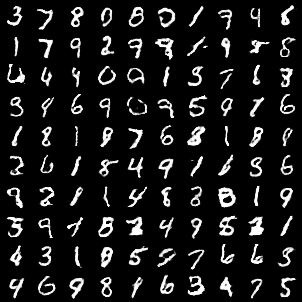

In [31]:
G.load_state_dict(torch.load("{}/g_baseline_normal_epoch_100.pth".format(args.models_dir)))
G.eval()
fname = save_fake_images(G, 'baseline_normal', args)
Image(fname)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0.5, 1.0, 'MDS output - Normal GAN')

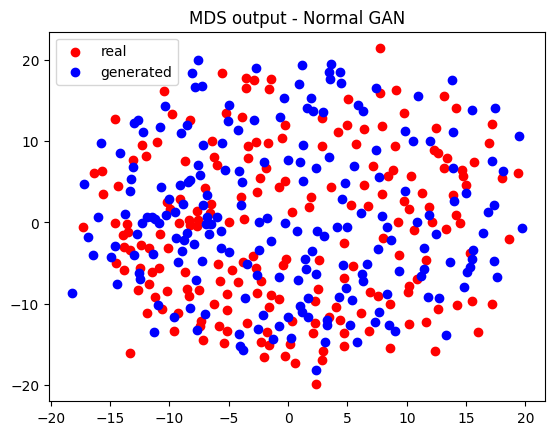

In [32]:
X_200_real = X_full.tensors[0][:200].reshape(args.batch_size, -1)
In = torch.normal(0, 1, size=(args.batch_size, args.latent_dim)).to(args.device)
with torch.no_grad():
    X_200_gan = G(In).reshape(args.batch_size, -1).cpu()
y = torch.concat([torch.ones(200), torch.zeros(200)])
mds = MDS(n_components=2)
X_2d = mds.fit_transform(torch.concat([X_200_real, X_200_gan]).numpy())
plt.scatter(X_2d[:200, 0], X_2d[:200, 1], c='r', label='real')
plt.scatter(X_2d[200:, 0], X_2d[200:, 1], c='b', label='generated')
plt.legend()
plt.title('MDS output - Normal GAN')

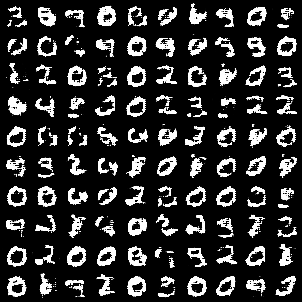

In [33]:
G.load_state_dict(torch.load("{}/g_baseline_FGAN_epoch_100.pth".format(args.models_dir)))
G.eval()
fname = save_fake_images(G, 'baseline_FGAN', args)
Image(fname)

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0.5, 1.0, 'MDS output - Fence GAN')

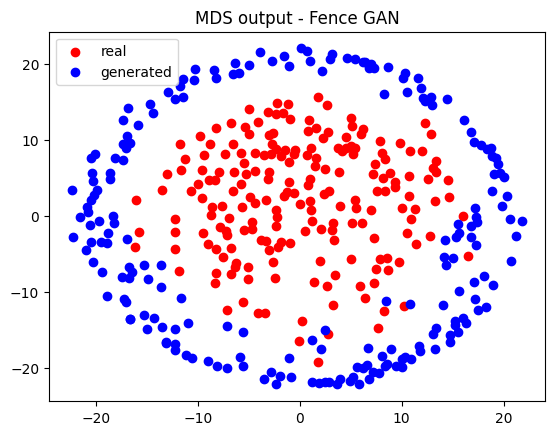

In [35]:
X_200_real = X_full.tensors[0][:200].reshape(args.batch_size, -1)
In = torch.normal(0, 1, size=(args.batch_size, args.latent_dim)).to(args.device)
with torch.no_grad():
    X_200_gan = G(In).reshape(args.batch_size, -1).cpu()
mds = MDS(n_components=2)
X_2d = mds.fit_transform(torch.concat([X_200_real, X_200_gan]).numpy())
plt.scatter(X_2d[:200, 0], X_2d[:200, 1], c='r', label='real')
plt.scatter(X_2d[200:, 0], X_2d[200:, 1], c='b', label='generated')
plt.legend()
plt.title('MDS output - Fence GAN')

In [12]:
def train_default_params(anomalous_class, args):
    torch.manual_seed(0)
    np.random.seed(0)
    
    train_loader, valid_loader, test_loader = get_data(anomalous_class, args.batch_size)
    
    G = Generator().to(args.device)
    D = Discriminator().to(args.device)
    G_optimizer = Adam(G.parameters(), lr=2e-5, weight_decay=1e-4, betas=(0.5, 0.999))
    D_optimizer = Adam(D.parameters(), lr=1e-5, weight_decay=1e-4, betas=(0.5, 0.999))

    
    print("========== START TRAINING GAN -- ANOMALOUS CLASS:{} ==========".format(anomalous_class))
    for epoch in range(1, 15+1):
        for data, _ in train_loader:
            _ = train_discriminator(D, G, D_optimizer, data, args)

    best_auprc = 0        
    for epoch in range(1, 100+1):

        # train
        for data, _ in train_loader:
            _ = train_discriminator(D, G, D_optimizer, data, args)
            _ = train_generator(D, G, G_optimizer, args)

        # valid
        if epoch < 10:
            continue
        auprc = compute_auprc(D, valid_loader, args.device)
        if auprc > best_auprc:
            best_auprc = auprc
            g_path = "{}/g_anomalous_{}_best.pth".format(args.models_dir, anomalous_class)
            d_path = "{}/d_anomalous_{}_best.pth".format(args.models_dir, anomalous_class)
            torch.save(G.state_dict(), g_path)
            torch.save(D.state_dict(), d_path)
            print("epoch:{}, best auprc:{:.4f}".format(epoch, auprc))
            
       
        
    g_path = "{}/g_anomalous_{}_final.pth".format(args.models_dir, anomalous_class)
    d_path = "{}/d_anomalous_{}_final.pth".format(args.models_dir, anomalous_class)
    torch.save(G.state_dict(), g_path)
    torch.save(D.state_dict(), d_path) 
    
    # load best model to evaluate on test set
    d_best_path = "{}/d_anomalous_{}_best.pth".format(args.models_dir, anomalous_class)
    D.load_state_dict(torch.load(d_best_path))
    auprc_best = compute_auprc(D, test_loader, args.device)
    print("SCORE ON TEST SET : {:.4f}".format(auprc_best))
    return auprc_best

In [13]:
auprc_scores = []
for i in range(10):
    auprc_scores.append(train_default_params(i, args))

100%|██████████| 9912422/9912422 [00:00<00:00, 99191714.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43842089.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21531350.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8373858.80it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

========== START TRAINING GAN -- ANOMALOUS CLASS:0 ==========
epoch:10, best auprc:0.6373
epoch:11, best auprc:0.6407
epoch:12, best auprc:0.6457
epoch:28, best auprc:0.6631
epoch:29, best auprc:0.6872
epoch:30, best auprc:0.7079
epoch:31, best auprc:0.7276
epoch:32, best auprc:0.7539
epoch:33, best auprc:0.7579
epoch:34, best auprc:0.7617
epoch:36, best auprc:0.7722
epoch:52, best auprc:0.7915
epoch:53, best auprc:0.8098
epoch:54, best auprc:0.8328
epoch:55, best auprc:0.8433
epoch:56, best auprc:0.8633
epoch:86, best auprc:0.8750
epoch:87, best auprc:0.8777
epoch:89, best auprc:0.8800
SCORE ON TEST SET : 0.8794
========== START TRAINING GAN -- ANOMALOUS CLASS:1 ==========
epoch:10, best auprc:0.9202
SCORE ON TEST SET : 0.9227
========== START TRAINING GAN -- ANOMALOUS CLASS:2 ==========
epoch:10, best auprc:0.6349
epoch:11, best auprc:0.6378
epoch:17, best auprc:0.6432
epoch:18, best auprc:0.6533
epoch:19, bes

Text(0.5, 1.0, 'AUPRC Scores on Test Set - MNIST')

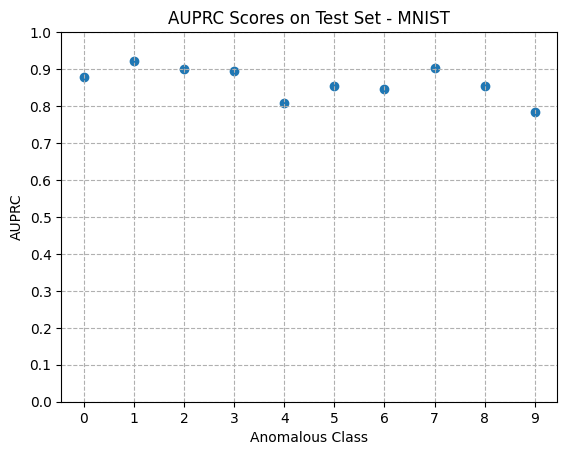

In [17]:
plt.scatter(range(10), auprc_scores)
plt.grid(linestyle='--')
plt.ylim((0,1))
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(range(10))
plt.xlabel('Anomalous Class')
plt.ylabel('AUPRC')
plt.title('AUPRC Scores on Test Set - MNIST')

(800, 784)


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


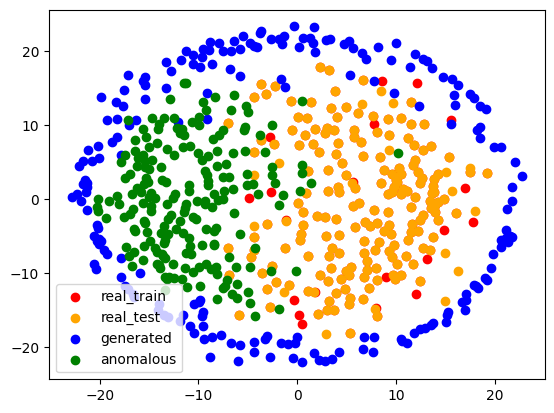

In [49]:
train_loader, valid_loader, test_loader = get_data(0, args.batch_size)
G = Generator().to(args.device)
G.load_state_dict(torch.load('/kaggle/input/fgan-wieghts-mnist/g_anomal_1_final.pth'))
visualize_G(G, train_loader, test_loader, args.device)

In [14]:
from sklearn.neighbors import KNeighborsRegressor



def visualize_G_D(G, D, train_loader, test_loader, device, n=200):
    G.eval()
    D.eval()
    torch.manual_seed(0)
    np.random.seed(0)
    
    X_real_anomal = test_loader.dataset.dataset.datasets[0].tensors[0][:n].reshape(n,-1).to(device)
    X_real_test = test_loader.dataset.dataset.datasets[1].dataset.tensors[0][:n].reshape(n,-1).to(device)
    with torch.no_grad():
        y_pred_train = D(X_real_test)
        y_pred_anomal = D(X_real_anomal)
    In = torch.normal(0, 1, size=(n, args.latent_dim)).to(device)
    with torch.no_grad():
        X_fake = G(In)
        y_pred_fake = D(X_fake)
    X_full = torch.concat([X_real_test, X_fake.reshape(n,-1), X_real_anomal]).cpu()
    y_pred_full = torch.concat([y_pred_train, y_pred_fake, y_pred_anomal]).cpu()

    mds = MDS(n_components=2, random_state=0)
    X_2d = mds.fit_transform(X_full)
    
    resolution = 100 # 100x100 background pixels
    X2d_xmin, X2d_xmax = np.min(X_2d[:,0]), np.max(X_2d[:,0])
    X2d_ymin, X2d_ymax = np.min(X_2d[:,1]), np.max(X_2d[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))
    background_model = KNeighborsRegressor(n_neighbors=1).fit(X_2d, y_pred_full.ravel())
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

    plt.figure(figsize=(8, 6))
    ticks = np.arange(0, 1.01, 0.2)
    plt.contourf(xx, yy, voronoiBackground, ticks, cmap='coolwarm', alpha=0.6, vmin=0, vmax=1)
    plt.colorbar()
    plt.scatter(X_2d[:n, 0], X_2d[:n, 1], c='r', label='normal')
    plt.scatter(X_2d[n:2*n, 0], X_2d[n:2*n, 1], c='b', label='generated')
    plt.scatter(X_2d[2*n:, 0], X_2d[2*n:, 1], c='g', label='anomalous')
    plt.legend()

    


(800, 784)


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


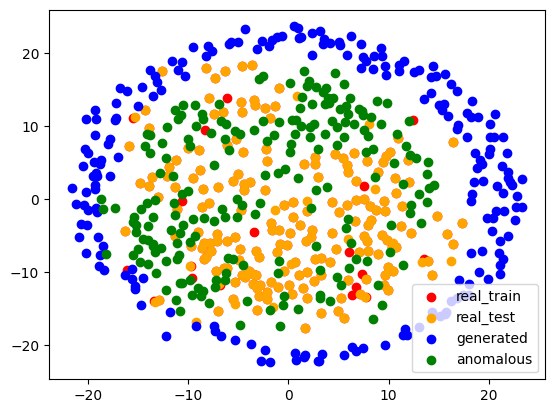

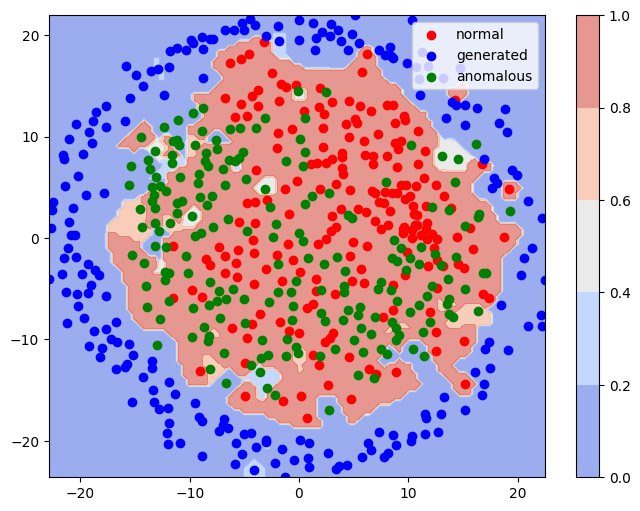

In [53]:
class_to_show = 2
g_path = "/kaggle/input/fgan-wieghts-mnist/g_anomal_{}_best.pth".format(class_to_show)
d_path = "/kaggle/input/fgan-wieghts-mnist/d_anomal_{}_best.pth".format(class_to_show)
G.load_state_dict(torch.load(g_path))
D.load_state_dict(torch.load(d_path))
train_loader, _, test_loader = get_data(class_to_show, args.batch_size)
visualize_G(G, train_loader, test_loader, args.device, n=200)
visualize_G_D(G, D, train_loader, test_loader, args.device)

(800, 784)


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


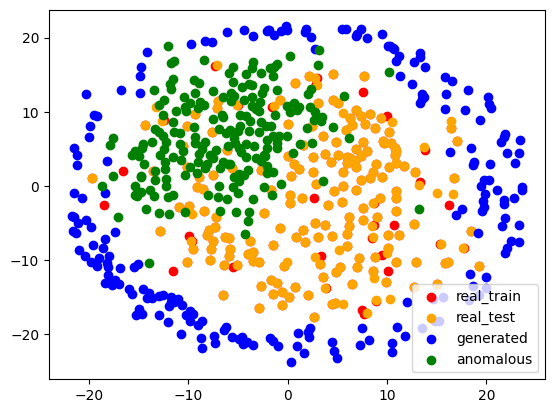

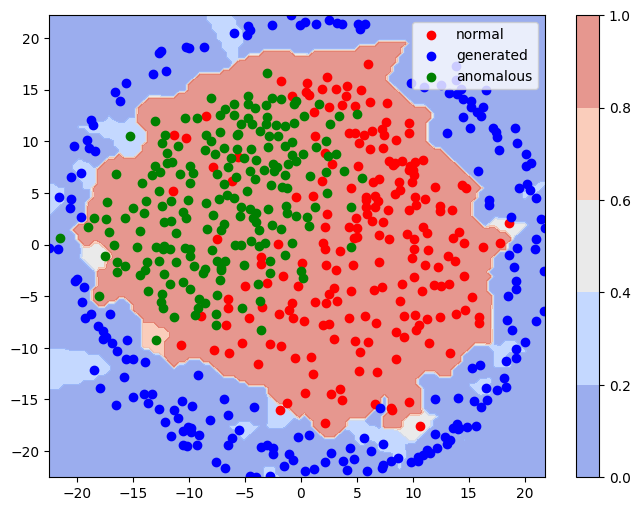

In [52]:
class_to_show = 4
g_path = "/kaggle/input/fgan-wieghts-mnist/g_anomal_{}_best.pth".format(class_to_show)
d_path = "/kaggle/input/fgan-wieghts-mnist/d_anomal_{}_best.pth".format(class_to_show)
G.load_state_dict(torch.load(g_path))
D.load_state_dict(torch.load(d_path))
train_loader, _, test_loader = get_data(class_to_show, args.batch_size)
visualize_G(G, train_loader, test_loader, args.device, n=200)
visualize_G_D(G, D, train_loader, test_loader, args.device)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead

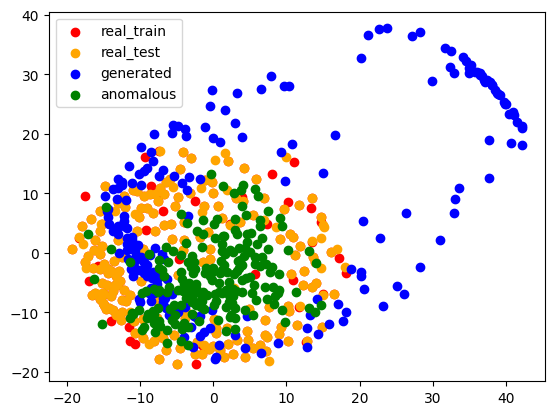

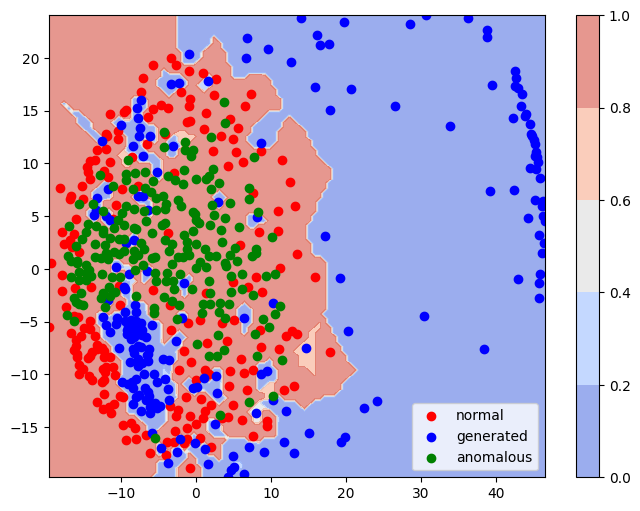

In [16]:
class_to_show = 9
G=Generator()
D=Discriminator()
g_path = "GAN_weights/g_anomal_{}_best.pth".format(class_to_show)
d_path = "GAN_weights/d_anomal_{}_best.pth".format(class_to_show)
G.load_state_dict(torch.load(g_path, map_location=torch.device('cpu')))
D.load_state_dict(torch.load(d_path, map_location=torch.device('cpu')))
train_loader, _, test_loader = get_data(class_to_show, args.batch_size)
visualize_G(G, train_loader, test_loader, args.device, n=200)
visualize_G_D(G, D, train_loader, test_loader, args.device)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead

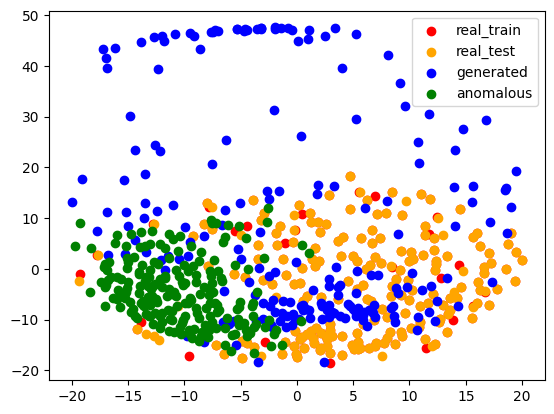

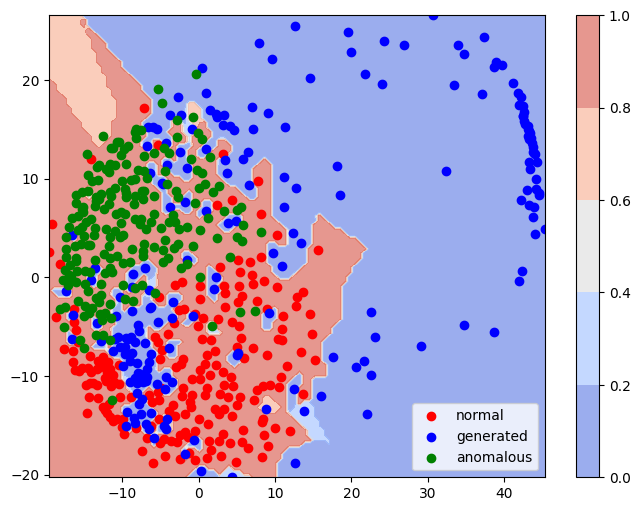

In [20]:
class_to_show = 6
G=Generator()
D=Discriminator()
g_path = "GAN_weights/g_anomal_{}_best.pth".format(class_to_show)
d_path = "GAN_weights/d_anomal_{}_best.pth".format(class_to_show)
G.load_state_dict(torch.load(g_path, map_location=torch.device('cpu')))
D.load_state_dict(torch.load(d_path, map_location=torch.device('cpu')))
train_loader, _, test_loader = get_data(class_to_show, args.batch_size)
visualize_G(G, train_loader, test_loader, args.device, n=200)
visualize_G_D(G, D, train_loader, test_loader, args.device)